## Helper functions

In [1]:
"""Imports"""
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from cot import Collection
import yaml

In [2]:
# Helper functions to call OpenAI model, system also generates reasoning
# this function lets the model reason (less frequently used than system_evaluate)

def system_experiment(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\nwith the following answer options:{answer_options}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_generate(input_dict)

def save_as_yaml(data, filepath):
    with open(filepath, 'w') as file:
        yaml.dump(data, file)

In [3]:
def system_evaluate(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\n
    with the following answer options:{answer_options}\n
    Reasoning: {reasoning}\n
    Answer: {answer}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_evals(input_dict)

In [4]:
def count_keys(lst):

    counts = {}
    for item in lst:
        if isinstance(item, list):
            sub_counts = count_keys(item)
            for key, value in sub_counts.items():
                counts[key] = counts.get(key, 0) + value
        else:
            counts[item] = counts.get(item, 0) + 1
    return counts

In [5]:
import yaml
def parse_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    lowest_obj = []
    scores_with_indicator = []
    for item in new_data[dataset][split]:
        flag = False
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                #scores_per_item.append(new_dict)
                flag = True
                variables_per_item.append(data)
        except:
            print("wrong output found")
            continue

        if flag == True:
            data = new_dict
            
            try:
                # Find the lowest value
                lowest_value = min(data.values())

                # Calculate the average value
                average_value = sum(data.values()) / len(data)

                # Find the key(s) of the lowest value
                lowest_keys = [key for key, value in data.items() if value == lowest_value]     
                lowest_obj.append(lowest_keys)

                # Add lowest and average values to the dictionary
                data['lowest'] = lowest_value
                data['average'] = average_value
            except:
                data['lowest'] = 'None'
                data['average'] = 'None'
                lowest_obj.append('None')
                print("non_int data found... continue")
                # print(data)

            scores_per_item.append(data)
            scores_with_indicator.append((data,item['generated_cot'][0]['answers'][0]['correct_answer']))

    #filter for strings
    lowest_tuples = []
    for i in range(len(lowest_obj)):
        lowest_tuples.append((lowest_obj[i],scores_with_indicator[i][1]))
    # print(lowest_tuples[0])
    filtered_lowest_tuples = [score_tuple for score_tuple in lowest_tuples if not any(isinstance(value, str) for value in score_tuple[0])]
         
    return scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator

In [6]:
def get_further_data(scores_per_item):
# Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys}

    # #check values for nonetype
    # for key, value in scores_per_objective.items():
    #     if value is not str:
    #         #print(key,value)
    #         continue

    averaged_data = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in scores_per_objective.items() if len([v for v in value if v is not None]) > 0}

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_objective, df

In [33]:
import yaml
import copy 

def parse_data_test(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    lowest_obj = []
    scores_with_indicator = []
    scores_with_lowest_keys = []
    for item in new_data[dataset][split]:
        flag = False
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                #scores_per_item.append(new_dict)
                flag = True
                variables_per_item.append(data)
        except:
            print("wrong output found")
            continue

        if flag == True:
            data = new_dict
            
            try:
                # Find the lowest value
                lowest_value = min(data.values())

                # Calculate the average value
                average_value = sum(data.values()) / len(data)

                # Find the key(s) of the lowest value
                lowest_keys = [key for key, value in data.items() if value == lowest_value]     
                lowest_obj.append(lowest_keys)

                # Add lowest and average values to the dictionary
                data['lowest_keys'] = lowest_keys
                data['lowest'] = lowest_value
                data['average'] = average_value
            except:
                data['lowest'] = 'None'
                data['average'] = 'None'
                lowest_obj.append('None')
                data['lowest_keys'] = 'None' #new
                print("non_int data found... continue")
                # print(data)

            scores_per_item.append(data)
            scores_with_lowest_keys.append((data,item['generated_cot'][0]['answers'][0]['correct_answer']))
            
            #add to scores_w_indicator without string data
            int_data = copy.deepcopy(data)
            del int_data['lowest_keys']
            scores_with_indicator.append((int_data,item['generated_cot'][0]['answers'][0]['correct_answer']))


    #filter for strings
    lowest_tuples = []
    for i in range(len(lowest_obj)):
        lowest_tuples.append((lowest_obj[i],scores_with_indicator[i][1]))
    # print(lowest_tuples[0])
    filtered_lowest_tuples = [score_tuple for score_tuple in lowest_tuples if not any(isinstance(value, str) for value in score_tuple[0])]
         
    return scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator, scores_with_lowest_keys

In [8]:
def fix_str_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if isinstance(value,str):
                scores_per_item.pop(i)
    return scores_per_item

In [9]:
def compare_true_false(obj_scores_true,obj_scores_false):

    averaged_true = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in obj_scores_true.items() if len([v for v in value if v is not None]) > 0}
    averaged_false = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in obj_scores_false.items() if len([v for v in value if v is not None]) > 0}


    # Convert the averaged data dictionary to a Pandas DataFrame
    df_true = pd.DataFrame.from_dict(averaged_true, orient='index', columns=['Average'])
    df_false = pd.DataFrame.from_dict(averaged_false, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df_true = df_true.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11','average']]
    df_false = df_false.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11','average']]

    # Rename the 'Average' column in each dataframe
    df_true.rename(columns={'Average': 'Average_true'}, inplace=True)
    df_false.rename(columns={'Average': 'Average_false'}, inplace=True)

    # Concatenate the dataframes horizontally along the columns
    merged_df = pd.concat([df_true, df_false], axis=1)

    merged_df['Difference'] = merged_df['Average_true'] - merged_df['Average_false']

  

    return merged_df

In [10]:
#helper functions for results
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statistics

def freq_bar_plot(scores_per_item): #later better axes
    average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
    # Create a histogram
    plt.hist(average_per_item, bins='auto', alpha=0.7)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Frequency of average score per item')
    plt.show()

def avg_true_false(data,average_per_item,dataset,split):
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = average_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    print("scores true:", statistics.mean(scores_true))
    print("scores false:", statistics.mean(scores_false))


In [11]:
import math

def standard_deviation(data):
    # First, compute the mean for each key.
    mean_data = {key: sum(value) / len(value) for key, value in data.items()}
    
    # Then, for each key, compute the sum of the squared differences from the mean.
    variance_data = {}
    for key, value in data.items():
        variance_data[key] = sum((x - mean_data[key]) ** 2 for x in value) / (len(value)-1)
    
    # Finally, compute the standard deviation for each key.
    standard_deviation_data = {key: math.sqrt(value) for key, value in variance_data.items()}
    
    return standard_deviation_data

In [12]:
from scipy.stats import mannwhitneyu

def u_test(scores_with_indicator):

    #filter for strings
    filtered_scores_with_indicator = [score_tuple for score_tuple in scores_with_indicator if not any(isinstance(value, str) for value in score_tuple[0].values())]
    

    scores, indicators= zip(*filtered_scores_with_indicator)

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    keys = set().union(*scores_true)
        # Create lists of values for each key
    scores_per_objective_true = {key: [d.get(key) for d in scores_true] for key in keys if key != "critique"} 

    keys = set().union(*scores_false)
        # Create lists of values for each key
    scores_per_objective_false = {key: [d.get(key) for d in scores_false] for key in keys if key != "critique"} 

    dict_1 = scores_per_objective_true
    dict_2 = scores_per_objective_false

    # make sure both dictionaries have the same keys
    assert dict_1.keys() == dict_2.keys()

    print(dict_1.keys())

    for key in dict_1.keys():
        u_stat, p_val = mannwhitneyu(dict_1[key], dict_2[key])
        print(f"For {key}, U-statistic is {u_stat:.2f} and the p-value is {p_val:.2f}")
    return scores_per_objective_true,scores_per_objective_false

In [13]:
import copy
"""Only use if none ans should not be false"""
def generate_without_none_ans(data):
    all_data = copy.deepcopy(data)
    true_data = copy.deepcopy(data)
    false_data = copy.deepcopy(data)


    false_data.evaluate()
    false_data.select_generated_cots(answer=False)
    false_data = false_data.filter(lambda x: len(x["generated_cot"])==1)

    true_data.evaluate()
    true_data.select_generated_cots(answer=True)
    true_data = true_data.filter(lambda x: len(x["generated_cot"])==1)

    full_data = false_data.merge(true_data)

    ids = full_data.dump_ids()

    # print(len(ids))

    # print(all_data)

    none_data = all_data.filter(lambda ex: ex['id'] not in ids)

    # print(none_data)

    none_ids = none_data.dump_ids()

    return all_data.filter(lambda ex: ex['id'] not in none_ids)



In [14]:
import pandas as df
# Modify the function to handle 'None' as string
def handle_string(df, column):
    for index, value in df[column].items():
        if isinstance(value, str):
            if value.lower() == 'none':
                df.loc[index, column] = None  # or np.nan
            else:
                continue

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [51]:
def practical_results(scores_with_indicator):
    data = scores_with_indicator
    data = [(t[0], False if t[1] is None else t[1]) for t in data]

    #all objs
    df = pd.DataFrame([t[0] for t in data])
    df['Indicator'] = [t[1] for t in data]

    #df_for_regression does not include variables created later 
    df_for_reg = copy.deepcopy(df)
    handle_string(df_for_reg,'average')
    handle_string(df,'average')

    df = df[df['average'].notna()]
    df = df.sort_values(by='average')

    df['Cumulative Count'] = df['Indicator'].cumsum()

    # Create a new column 'Cumulative Count False' that contains the cumulative count of 'False' values
    df['Cumulative Count False'] = (~df['Indicator']).cumsum()

    # Plot graph with 'Average' as x-axis and 'Cumulative Count' and 'Cumulative Count False' as y-axis
    plt.figure(figsize=(10, 6))
    plt.plot(df['average'], df['Cumulative Count'], label='Correct')
    plt.plot(df['average'], df['Cumulative Count False'], label='Incorrect', color='red')
    plt.xlabel('Average Objective Score ') #Distribution of (in)correct answers when average objective score increases
    plt.ylabel('Cumulative Sum of Questions Evaluated')
    plt.title('Mapping of Model Accuracy to Objective Scores')
    plt.grid(True)
    plt.legend()
    plt.show()

    df['Difference'] = df['Cumulative Count False'] - df['Cumulative Count']

    # Find the maximum value in 'Difference'
    max_diff = df['Difference'].max()

    # Find the corresponding 'Cumulative Count True' and 'Cumulative Count False' values
    # corresponding_values = df[df['Difference'] == max_diff][['Cumulative Count', 'Cumulative Count False']]
    # print("Maximum difference between :", max_diff)
    # print("Corresponding Values:")
    # print(corresponding_values)

    #out of sample accuracy
    df_for_reg = df_for_reg[df_for_reg['average'].notna()]

    for column in df_for_reg.columns:
        if column.startswith('obj_'):
            is_float = df_for_reg[column].apply(lambda x: not isinstance(x, str))
            df_for_reg = df_for_reg[is_float]

    X = df_for_reg.drop('Indicator', axis=1)  # Features
    y = df_for_reg['Indicator'].values  # Target variable

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifier = LogisticRegression(max_iter=10000)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy with 20% test size:", accuracy)

    # training accuracy:
    classifier = LogisticRegression(max_iter=10000)
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print("Training Accuracy:", accuracy)

    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Get the correlation values with the 'Indicator' variable
    indicator_correlation = correlation_matrix['Indicator']
    print("\nCorrelations")
    print(indicator_correlation)
    print("\n")

    return df_for_reg

In [54]:
def reg_with_one_hot(scores_with_indicator):

    print("Analysis including one-hot-encoding of the objective(s) with the lowest score")

    data = scores_with_indicator
    data = [(t[0], False if t[1] is None else t[1]) for t in data]

    #all objs
    df_for_reg = pd.DataFrame([t[0] for t in data])
    df_for_reg['Indicator'] = [t[1] for t in data]

    # Create a temporary dataframe for exploding 'lowest keys'
    df_temp = df_for_reg['lowest_keys'].explode()

    # Apply one-hot encoding
    df_temp = pd.get_dummies(df_temp, prefix='lowest_keys')

    # Aggregate the data back
    df_temp = df_temp.groupby(df_temp.index).sum()

    # Now join this back with the original dataframe
    df_for_reg = df_for_reg.join(df_temp)

    df_for_reg = df_for_reg.drop('lowest_keys', axis=1)

    for column in df_for_reg.columns:
        if column.startswith('obj_'):
            is_float = df_for_reg[column].apply(lambda x: not isinstance(x, str))
            df_for_reg = df_for_reg[is_float]

    # X = df_for_reg['average'].values.reshape(-1, 1)  # Features
    X = df_for_reg.drop('Indicator', axis=1)  # Features
    y = df_for_reg['Indicator'].values  # Target variable

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifier = LogisticRegression(max_iter=10000)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # training accuracy:
    classifier = LogisticRegression(max_iter=10000)
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print("Training Accuracy:", accuracy)

    # Calculate the correlation matrix
    correlation_matrix = df_for_reg.corr()

    # Get the correlation values with the 'Indicator' variable
    indicator_correlation = correlation_matrix['Indicator'].filter(like='lowest_keys_obj')

    print(indicator_correlation)

    # Get the coefficients and intercept
    coefficients = classifier.coef_
    intercept = classifier.intercept_

    # Print the coefficients and intercept
    # print("Coefficients:", coefficients)
    # print("Intercept:", intercept)

    #check feature selection
    from sklearn.feature_selection import SelectFromModel

    # Perform feature selection using L1 regularization
    selector = SelectFromModel(classifier, threshold=None)
    selector.fit(X_train, y_train)

    # Get selected feature indices
    selected_feature_indices = selector.get_support(indices=True)

    # Get selected feature names
    selected_feature_names = X_train.columns[selected_feature_indices]

    # Print selected feature names
    
    print("\nSelected Features after L1 regularization:")
    print(selected_feature_names)

## Summary Table

In [ ]:
"""

"""

In [71]:
import pandas as pd

data = {
    'Index': ['cohere_supervised_by_4', '3_supervised_by_3', '4_supervised_by_3', '4_supervised_by_4', '3_supervised_by_4', 'cohere_supervised_by_3'],
    'Training Accuracy': [0.79, 0.63, 0.79, 0.81, 0.77, 0.64],
    'Highest Correlation': [('obj_8', 0.479714), ('obj_4', 0.167537), ('obj_3', 0.092901), ('obj_8', 0.264401), ('obj_8', 0.473946), ('obj_8', 0.169337)],
    'Training Accuracy with 1-hot-encoding': [0.784, 0.6381909548, 0.797188755, 0.802, 0.7775551102, 0.6533066132],
    'Highest 1-hot-encoding Correlation Variable': [('lowest_keys_obj_11', -0.312880), ('lowest_keys_obj_10', 0.136698), ('lowest_keys_obj_5', 0.10201), ('lowest_keys_obj_9', 0.195307), ('lowest_keys_obj_9', 0.381784), ('lowest_keys_obj_2', 0.024953)]
}

df = pd.DataFrame(data)

# Move '4_supervises_cohere' row to the last position
df = pd.concat([df[df['Index'] != 'cohere_supervised_by_4'], df[df['Index'] == 'cohere_supervised_by_4']])

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

# Print the updated DataFrame
df

"""GPT-3.5 supervising GPT-4 is more indicative for a correct answer than vice versa"""

,Index,Training Accuracy,Highest Correlation,Training Accuracy with 1-hot-encoding,Highest 1-hot-encoding Correlation Variable
0,3_supervised_by_3,0.63,"(obj_4, 0.167537)",0.638191,"(lowest_keys_obj_10, 0.136698)"
1,4_supervised_by_3,0.79,"(obj_3, 0.092901)",0.797189,"(lowest_keys_obj_5, 0.10201)"
2,4_supervised_by_4,0.81,"(obj_8, 0.264401)",0.802000,"(lowest_keys_obj_9, 0.195307)"
3,3_supervised_by_4,0.77,"(obj_8, 0.473946)",0.777555,"(lowest_keys_obj_9, 0.381784)"
4,cohere_supervised_by_3,0.64,"(obj_8, 0.169337)",0.653307,"(lowest_keys_obj_2, 0.024953)"
5,cohere_supervised_by_4,0.79,"(obj_8, 0.479714)",0.784000,"(lowest_keys_obj_11, -0.31288)"


## Data

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

wrong output found
non_int data found... continue


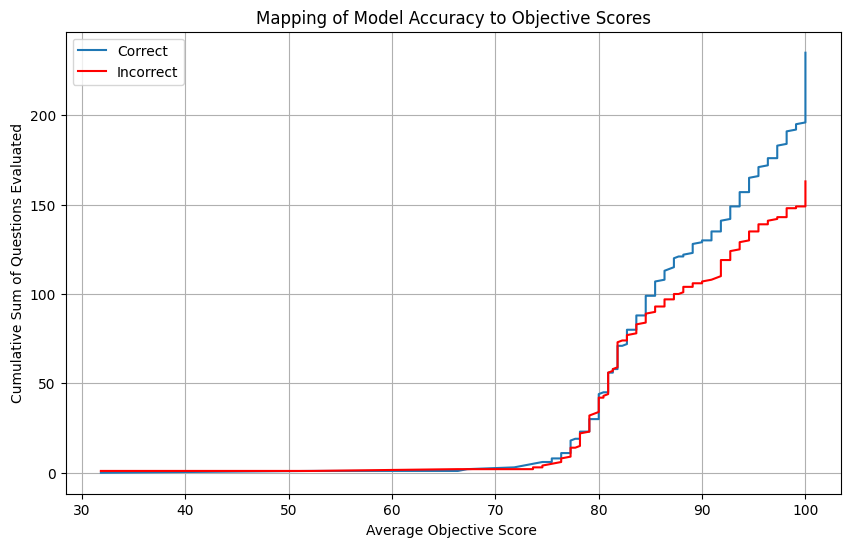

Accuracy with 20% test size: 0.5875
Training Accuracy: 0.628140703517588

Correlations
obj_1                     0.117501
obj_2                     0.093427
obj_3                     0.111022
obj_4                     0.167537
obj_5                     0.113342
obj_6                     0.121151
obj_7                     0.113241
obj_8                     0.135372
obj_9                     0.099160
obj_10                    0.136002
obj_11                    0.166411
lowest                    0.142334
average                   0.143391
Indicator                 1.000000
Cumulative Count          0.160791
Cumulative Count False    0.145938
Difference               -0.182317
Name: Indicator, dtype: float64


Analysis including one-hot-encoding of the objective(s) with the lowest score
Accuracy: 0.55
Training Accuracy: 0.6381909547738693
lowest_keys_obj_1     0.110316
lowest_keys_obj_10    0.136698
lowest_keys_obj_11    0.084850
lowest_keys_obj_2     0.121087
lowest_keys_obj_3     0.09797

In [55]:
# GPT-3.5 supervised by GPT-3.5
data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_500 = data_400.merge(data_100)
data = data_500
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator, scores_with_lowest_keys = parse_data_test(data,idx_cot=1,dataset='med_qa',split='test')
df_for_reg = practical_results(scores_with_indicator)
reg_with_one_hot(scores_with_lowest_keys)



Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

non_int data found... continue
non_int data found... continue


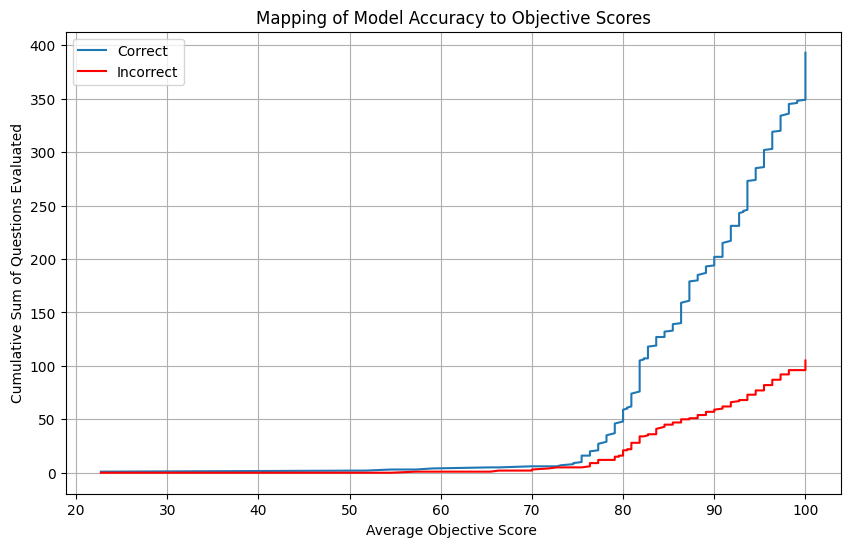

Accuracy with 20% test size: 0.78
Training Accuracy: 0.7871485943775101

Correlations
obj_1                     0.011184
obj_2                     0.082436
obj_3                     0.092901
obj_4                     0.064687
obj_5                    -0.016971
obj_6                     0.052358
obj_7                     0.042715
obj_8                     0.053883
obj_9                     0.030980
obj_10                    0.040621
obj_11                    0.045854
lowest                    0.024303
average                   0.048616
Indicator                 1.000000
Cumulative Count          0.051581
Cumulative Count False    0.045239
Difference               -0.053667
Name: Indicator, dtype: float64


Analysis including one-hot-encoding of the objective(s) with the lowest score
Accuracy: 0.78
Training Accuracy: 0.7971887550200804
lowest_keys_obj_1     0.045105
lowest_keys_obj_10    0.015989
lowest_keys_obj_11    0.045810
lowest_keys_obj_2     0.037769
lowest_keys_obj_3     0.013294

In [57]:
# GPT-4 supervised by GPT-3.5
data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-3.5-turbo.json")
data_100 = Collection.from_json("./med_qa_100_first_gpt-4_gpt-3.5-turbo.json")
data_500 = data_400.merge(data_100)
data = data_500
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator, scores_with_lowest_keys = parse_data_test(data,idx_cot=1,dataset='med_qa',split='test')
df_for_reg = practical_results(scores_with_indicator)
reg_with_one_hot(scores_with_lowest_keys)


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

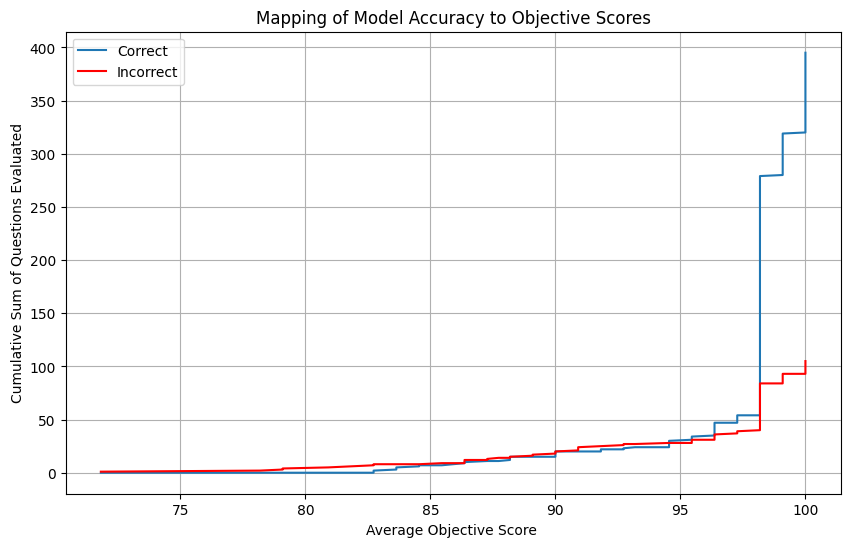

Accuracy with 20% test size: 0.79
Training Accuracy: 0.806

Correlations
obj_1                     0.171472
obj_2                     0.238102
obj_3                     0.067392
obj_4                     0.244681
obj_5                     0.121717
obj_6                     0.241012
obj_7                     0.204262
obj_8                     0.264401
obj_9                     0.025495
obj_10                    0.206819
obj_11                    0.209433
lowest                    0.263987
average                   0.274466
Indicator                 1.000000
Cumulative Count          0.193491
Cumulative Count False    0.219420
Difference               -0.184489
Name: Indicator, dtype: float64


Analysis including one-hot-encoding of the objective(s) with the lowest score
Accuracy: 0.81
Training Accuracy: 0.802
lowest_keys_obj_1     0.085879
lowest_keys_obj_10    0.080088
lowest_keys_obj_11   -0.015751
lowest_keys_obj_2     0.048825
lowest_keys_obj_3     0.075408
lowest_keys_obj_4     0.0

In [58]:
# GPT-4 supervised by GPT-4
data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-4_gpt-4.json")
data_500 = data_400.merge(data_100)
data = data_500
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator, scores_with_lowest_keys = parse_data_test(data,idx_cot=1,dataset='med_qa',split='test')
df_for_reg = practical_results(scores_with_indicator)
reg_with_one_hot(scores_with_lowest_keys)



Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

non_int data found... continue


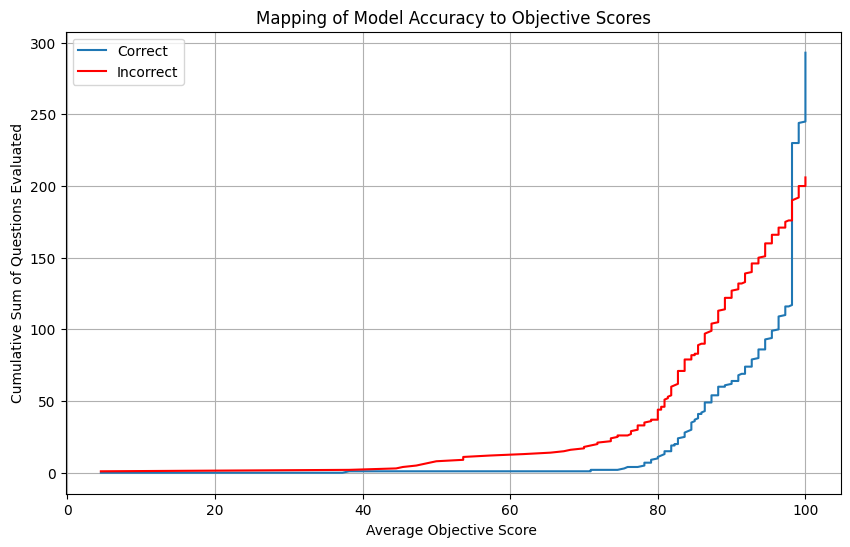

Accuracy with 20% test size: 0.77
Training Accuracy: 0.7715430861723447

Correlations
obj_1                     0.234904
obj_2                     0.411084
obj_3                     0.122252
obj_4                     0.411661
obj_5                     0.262727
obj_6                     0.332656
obj_7                     0.330114
obj_8                     0.473946
obj_9                     0.194097
obj_10                    0.376807
obj_11                    0.370552
lowest                    0.463773
average                   0.412101
Indicator                 1.000000
Cumulative Count          0.444381
Cumulative Count False    0.451423
Difference               -0.278741
Name: Indicator, dtype: float64


Analysis including one-hot-encoding of the objective(s) with the lowest score
Accuracy: 0.71
Training Accuracy: 0.7775551102204409
lowest_keys_obj_1     0.198740
lowest_keys_obj_10    0.159154
lowest_keys_obj_11   -0.149754
lowest_keys_obj_2     0.174114
lowest_keys_obj_3     0.198889

In [59]:
#GPT-3.5 supervised by GPT-4
import pandas as pd
data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-4.json")
data_500 = data_400.merge(data_100)
data = data_500
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator, scores_with_lowest_keys = parse_data_test(data,idx_cot=1,dataset='med_qa',split='test')
df_for_reg = practical_results(scores_with_indicator)
reg_with_one_hot(scores_with_lowest_keys)



non_int data found... continue
non_int data found... continue


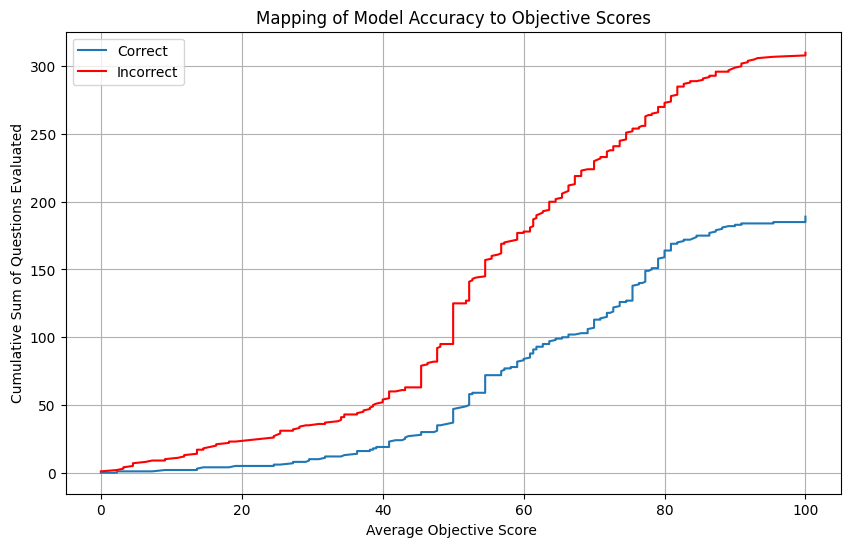

Accuracy with 20% test size: 0.6
Training Accuracy: 0.6352705410821643

Correlations
obj_1                     0.126373
obj_2                     0.117741
obj_3                     0.136856
obj_4                     0.155557
obj_5                     0.113137
obj_6                     0.161567
obj_7                     0.116791
obj_8                     0.169337
obj_9                     0.145016
obj_10                    0.168426
obj_11                    0.146365
lowest                    0.155997
average                   0.160982
Indicator                 1.000000
Cumulative Count          0.157658
Cumulative Count False    0.154984
Difference                0.141780
Name: Indicator, dtype: float64


Analysis including one-hot-encoding of the objective(s) with the lowest score
Accuracy: 0.6
Training Accuracy: 0.6533066132264529
lowest_keys_obj_1     0.020543
lowest_keys_obj_10    0.014159
lowest_keys_obj_11   -0.091904
lowest_keys_obj_2     0.024953
lowest_keys_obj_3    -0.007590
l

In [60]:
#Cohere supervised by GPT-3.5-turbo
data = Collection.from_json("./med_qa_first_cohere_gpt-3.5-turbo.json")
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator, scores_with_lowest_keys = parse_data_test(data,idx_cot=1,dataset='med_qa',split='test')
df_for_reg = practical_results(scores_with_indicator)
reg_with_one_hot(scores_with_lowest_keys)



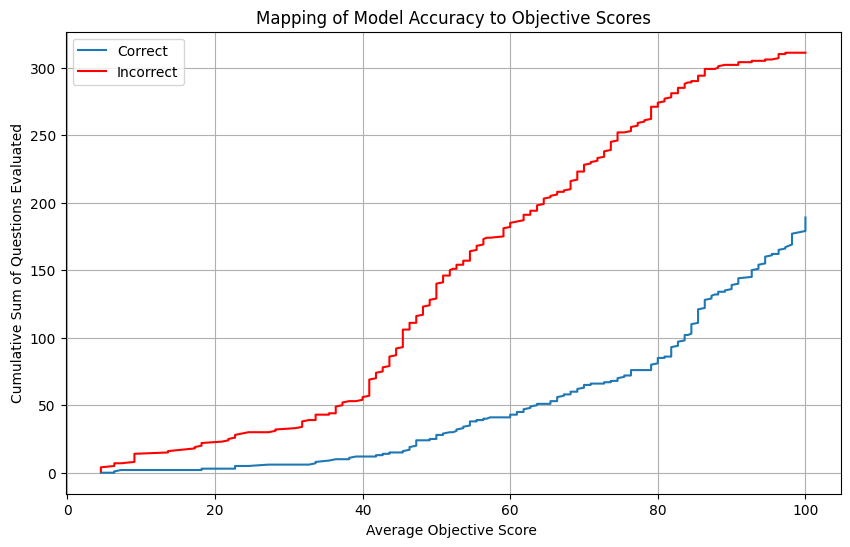

Accuracy with 20% test size: 0.74
Training Accuracy: 0.792

Correlations
obj_1                     0.208893
obj_2                     0.385459
obj_3                     0.143985
obj_4                     0.422895
obj_5                     0.272391
obj_6                     0.398196
obj_7                     0.329369
obj_8                     0.479714
obj_9                     0.348137
obj_10                    0.398248
obj_11                    0.412624
lowest                    0.456141
average                   0.430658
Indicator                 1.000000
Cumulative Count          0.491517
Cumulative Count False    0.422128
Difference                0.287405
Name: Indicator, dtype: float64


Analysis including one-hot-encoding of the objective(s) with the lowest score
Accuracy: 0.72
Training Accuracy: 0.784
lowest_keys_obj_1     0.192394
lowest_keys_obj_10   -0.032053
lowest_keys_obj_11   -0.312880
lowest_keys_obj_2     0.080810
lowest_keys_obj_3    -0.002197
lowest_keys_obj_4    -0.0

In [62]:
#Cohere supervised by GPT-4 
# note idx_cot = 2 here
data = Collection.from_json("./med_qa_first_cohere_gpt-4.json")
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator, scores_with_lowest_keys = parse_data_test(data,idx_cot=2,dataset='med_qa',split='test')
df_for_reg = practical_results(scores_with_indicator)
reg_with_one_hot(scores_with_lowest_keys)